## Model Selection and Putting it all together

*a priori* we do not know which model will perform the best. Depending on the data, simple models (such as linear regression) may be the most performant, while for other data, complex deep learning algorithms. It is important to note, THE MOST COMPLEX ALGORITHM IS NOT ALWAYS THE BEST PERFORMING. As a result, multiple models are tested initially and their performance evaluated. The top performing (or top n performing) are then down selected for more significant optimization. 

In [1]:
import pandas as pd
import os
import numpy as np
import json
import sys
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from skopt.callbacks import DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_auc_score, precision_score, recall_score, accuracy_score, \
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
os_platform = sys.platform

if os_platform == 'windows':
    RootDir = '\\'.join(os.getcwd().split('\\')[0:-2])
else:
    RootDir = '/'.join(os.getcwd().split('/')[0:-2])
os.chdir(RootDir)

In [3]:
%run "./notebooks/common/function_library.ipynb"

In [4]:
train_impute = pd.read_csv('data/train_smote.csv')
test_impute = pd.read_csv('data/test_impute.csv')

In [5]:
train_features = train_impute.columns[1:]
target_feature = 'readmit_flag'

# Get X/y
X_train = train_impute[train_features]
X_test = test_impute[train_features]
y_train = train_impute[target_feature]
y_test = test_impute[target_feature]

In [6]:
# Json files containig hyperparameters. 
param_files = [
    'lr_params.json',
    'knn_params.json',
    'svm_params.json',
    'mlp_params.json',
    'rf_params.json',
    'gb_params.json',
]

param_dict = dict()

for iFile in param_files:
    iKey = iFile.split('_')[0]
    with open(os.path.join('input',iFile),'r') as f:
        params = json.load(f)
        param_dict[iKey] = BuildSamplingDict(params)

### Model Types 

Many different models exist for machine learning and deep learning applications, with new architectures being developed and released every day. Below, we test some of the most common models, which are briefly outlined and explained below.

#### Logistic Regression

Perhaps one of the best known models, logistic regression fits a first order polynomial with parameters for each feature, which constitute the weight to the prediction output. Non-linearity can be introduced by fitting to a polynomial of degree n. 

For more see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### K-Nearest Neighbors

An unsupervised learning approach, data is ordered into multiple clusters corresponding to different classes using some specified metric (often distance). New preidctions can be made by finding the cluster closest in distance to the data point of interest.  

For more see https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

#### Support Vector Machine

Support vector machines work by drawing boundaries between different classes in the subspace of features. This effectively separates the classes into different subspaces, allowing predictions of new features by identifying which subspace they are present in.

For more see https://scikit-learn.org/stable/modules/svm.html

#### Multi-layer Perceptron

A simple neural network, this multilayer perceptron model is comprised of an input layer, single hidden layer and output layer. 

For more see https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

#### Random Forest

Previosly described, an ensemble method leveraging multiple decision trees

For more see https://scikit-learn.org/stable/modules/svm.html

#### Gradient Boosting

Another ensemble method using tree-based methods. The primary distinction is the incorporation of coefficients to fit the trees to the residuals (errors). This allows the model to focus on classes that is makes more mistakes

For more see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [7]:
estimator_dict = {
    'lr': LogisticRegression(max_iter=1000),
    'knn': KNeighborsClassifier(),
    'svm': SVC(probability=True),
    'mlp': MLPClassifier(max_iter=1000),
    'rf': RandomForestClassifier(),
    'gb': GradientBoostingClassifier()
}

In [8]:
model_dict = dict()

for iKey in estimator_dict:

    print(f'##### Now processing model {iKey} #####')

    model_dict[iKey] = TuneHyperParameters(
        X_train=X_train, y_train=y_train, estimator=estimator_dict[iKey],param_dict=param_dict[iKey])
    
    test_score = EvaluateModel(X_test=X_test,y_test=y_test,estimator=model_dict[iKey])
    print(f'  > Test score was {test_score}')   

##### Now processing model lr #####
  > Test score was 0.4763013729012798
##### Now processing model knn #####
  > Test score was 0.5699684314029912
##### Now processing model svm #####


/home/parallels/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/parallels/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  > Test score was 0.5659354876867686
##### Now processing model mlp #####


/home/parallels/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


  > Test score was 0.561314791403287
##### Now processing model rf #####
  > Test score was 0.5649300241754829
##### Now processing model gb #####
  > Test score was 0.5787107887713383


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


##### Now processing model lr #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9407407407407408
F1 Score: 0.027027027027027025
AUC: 0.4763013729012798
Precision: 0.02197802197802198
Recall: 0.03508771929824561
logloss: 2.1359202008365723
PPV: 0.02197802197802198
NPV: 0.9764856776400171
True Negative: 2284
False Positive: 89
False Negative: 55
True Positive: 2
##### Now processing model knn #####
Accuracy: 0.8395061728395061
F1 Score: 0.0625
AUC: 0.5699684314029912
Precision: 0.036211699164345405
Recall: 0.22807017543859648
logloss: 5.784783877265716
PPV: 0.036211699164345405
NPV: 0.9787542250120714
True Negative: 2027
False Positive: 346
False Negative: 44
True Positive: 13
##### Now processing model svm #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9037037037037037
F1 Score: 0.05645161290322581
AUC: 0.5659354876867686
Precision: 0.03664921465968586
Recall: 0.12280701754385964
logloss: 3.4708703263594294
PPV: 0.03664921465968586
NPV: 0.9776686020544886
True Negative: 2189
False Positive: 184
False Negative: 50
True Positive: 7
##### Now processing model mlp #####
Accuracy: 0.9218106995884774
F1 Score: 0.06862745098039216
AUC: 0.561314791403287
Precision: 0.047619047619047616
Recall: 0.12280701754385964
logloss: 2.818228042770477
PPV: 0.047619047619047616
NPV: 0.9780989925536575
True Negative: 2233
False Positive: 140
False Negative: 50
True Positive: 7
##### Now processing model rf #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8921810699588477
F1 Score: 0.05755395683453238
AUC: 0.5649300241754829
Precision: 0.03619909502262444
Recall: 0.14035087719298245
logloss: 3.8861881431887637
PPV: 0.03619909502262444
NPV: 0.9778180172023541
True Negative: 2160
False Positive: 213
False Negative: 49
True Positive: 8
##### Now processing model gb #####
Accuracy: 0.8699588477366255
F1 Score: 0.07058823529411765
AUC: 0.5787107887713383
Precision: 0.04240282685512368
Recall: 0.21052631578947367
logloss: 4.687158218502478
PPV: 0.04240282685512368
NPV: 0.9790405216581276
True Negative: 2102
False Positive: 271
False Negative: 45
True Positive: 12


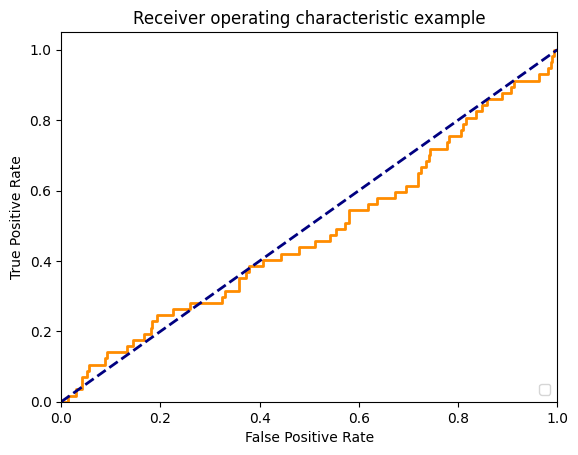

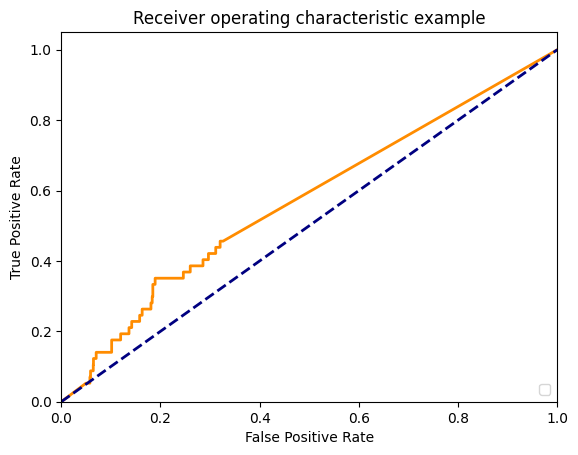

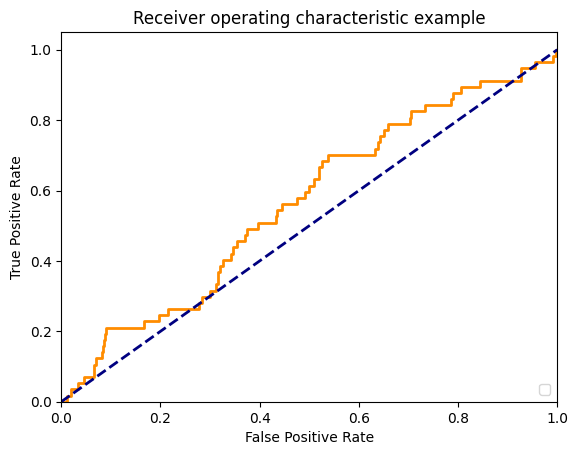

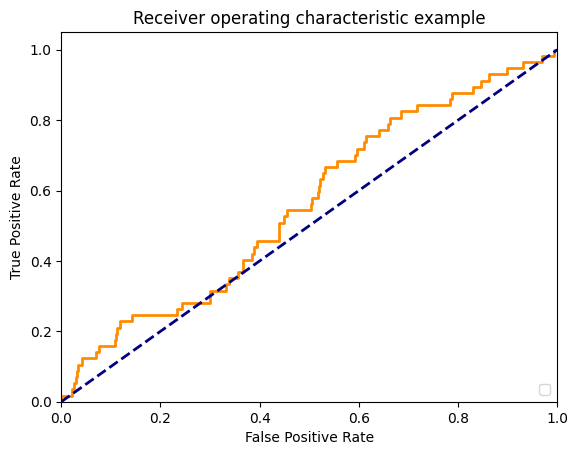

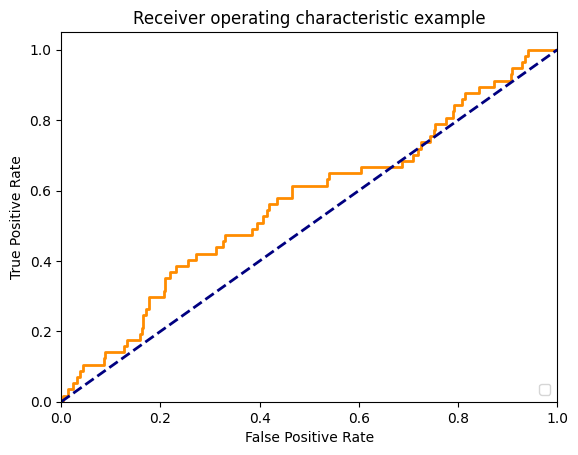

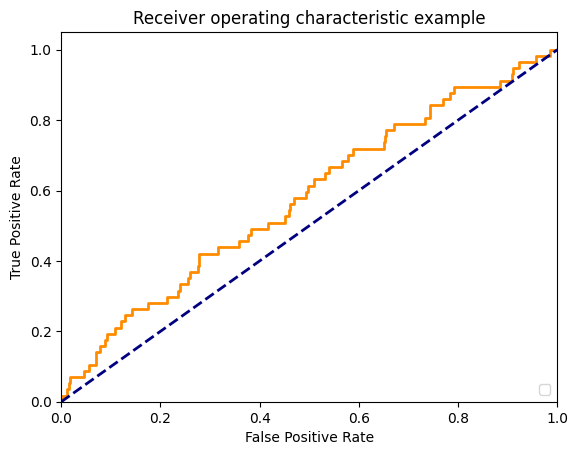

In [9]:
for iKey in model_dict:

    print(f'##### Now processing model {iKey} #####')
    LogMetrics(model_dict[iKey],X_test, y_test)

In [10]:
iKey = 'gb'
filename = 'data/best_model_'+iKey+'.sav'
joblib.dump(model_dict[iKey], filename)

['data/best_model_gb.sav']